# Transit Service Areas - definition and summaries

Notebook is an implementation of https://github.com/BayAreaMetro/bayarea_urbansim/blob/main/scripts/proximity2transit.py. It will be turned into a standalone script.

In words, the process is going from a point layer of transit stops with information on size and headways and build status. Those are to be buffered, and a hierarchy is active, favoring rail over non-rail, and shorter headways over longer headways. Service areas a built by overlays, and parcels are classified by the service area they fall within. Finally model runs are summarized by these service areas, and other attributes.

# Paraphernalia

In [1]:
import os
import sys
import time
import traceback
import logging
import datetime

import pandas as pd
import geopandas as gpd
import fiona

import seaborn as sns
import matplotlib.pyplot as plt


/Users/aolsen/opt/anaconda3/envs/geo_env_2/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_64403/4184460065.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Sha

In [181]:
# DVUTILS_LOCAL_CLONE_PATH = "/Users/aolsen/Documents/GitHub/dvutils"
# sys.path.insert(0, DVUTILS_LOCAL_CLONE_PATH)
# from utils_io import *
user = os.getlogin()
user

'aolsen'

In [3]:
# gdb_path = '/Volumes/Data/Models/Scratch/AO/workspace_2024_0315_1017.gdb'
gdb_path = '/Volumes/Data/Models/Data/GIS layers/JobsHousingTransitProximity/workspace_2020_1008_2343.gdb'

#fiona.listlayers(gdb_path)
v2020_fbp_classes = gpd.read_file(gdb_path,layer='trn_bp_cat5')
v2020_cur_classes = gpd.read_file(gdb_path,layer='trn_cur_cat5')
v2020_np_classes = gpd.read_file(gdb_path,layer='trn_np_cat5')

In [4]:
v2020_fbp_classes = gpd.read_file(gdb_path,layer='trn_bp_cat5')
v2020_cur_classes = gpd.read_file(gdb_path,layer='trn_cur_cat5')
v2020_np_classes = gpd.read_file(gdb_path,layer='trn_np_cat5')

In [5]:
fiona.listlayers(gdb_path)
v2020_transit_current = gpd.read_file(gdb_path,layer='transit_current')
v2020_transit_potential = gpd.read_file(gdb_path,layer='transit_potential')
v2020_transit_cur_major = gpd.read_file(gdb_path,layer='trn_cur_major')

In [6]:
# transit_areas_current_dissolved.explore(column='cat5',cmap='Set3')

In [7]:
# v2020_fbp_classes.explore(column='Service_Level',cmap='Set3')

## Paths
### AGOL URLs, and local versions until we get utils working

In [8]:
ANALYSIS_CRS = 'EPSG:26910'

In [9]:
WORKING_DIR = os.path.abspath(".")

In [10]:
MTC_ONLINE_TRANSIT_URL = 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/transitstops_existing_planned_2021/FeatureServer/0'

MTC_ONLINE_BACOUNTY_URL = 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/ArcGIS/rest/services/region_county/FeatureServer/0'

MTC_ONLINE_TAZ_URL = 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/ArcGIS/rest/services/transportation_analysis_zones_1454/FeatureServer/0'

#MTC_ONLINE_TRACT_URL = 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/ArcGIS/rest/services/Bay_Area_Census_Tracts_2010/FeatureServer/0'
MTC_ONLINE_TRACT_URL = 'https://services3.arcgis.com/i2dkYWmb4wHvYPda/ArcGIS/rest/services/cocs_ACS2014_2018/FeatureServer/0'

In [11]:
tract_epc_path = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/proximity/communities_of_concern_2020_acs2018_-5728172521147435275.gpkg'
tract_epc21_path = '/Volumes/Data/Models/Data/Equity Priority Communities/PBA50/EPCs_ACS2018_tbl.csv'
tract_epc24_path = '/Volumes/Data/Models/Data/Equity Priority Communities/PBA50Plus/epc_acs2022.csv'
county_path = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/proximity/region_county_-6301486166122500334.gpkg'
transit_path = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/proximity/transitstops_existing_planned_2021_2777787894694541529.gpkg'
taz_path = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/proximity/transportation_analysis_zones_1454_5961535026220395633.gpkg'

In [12]:
tract_hra_2023_path = '/Volumes/Data/Models/Data/HCD/final_2023_public.xlsx'
tract_hra_2023 = pd.read_excel(tract_hra_2023_path,'BayArea',dtype={'Census Tract':str}).set_index('Census Tract')['Final Category']

In [13]:
tract_hra_2019_path = '/Volumes/Data/Models/Data/HCD/final-opportunity-map-statewide-summary-table.xlsx'
tract_hra_2019 = pd.read_excel(tract_hra_2019_path, 'BayArea', dtype={
                               'Tract FIPS Code': str}).set_index('Tract FIPS Code')['Final Category']
tract_hra_2019 = tract_hra_2019.fillna('Missing')

In [14]:
tract_epc21_file = pd.read_csv(tract_epc21_path)
tract_epc24_file = pd.read_csv(tract_epc24_path)

In [15]:
county_file = gpd.read_file(county_path)
county_file = county_file.to_crs(ANALYSIS_CRS)

In [16]:
transit_file = gpd.read_file(transit_path)
transit_file = transit_file.to_crs(ANALYSIS_CRS)

In [17]:
taz_file = gpd.read_file(taz_path)
taz_file = taz_file.to_crs(ANALYSIS_CRS)

In [18]:
# Enforce 11-character tract GEOID
tract_epc21_file['geoid10'] = tract_epc21_file.geoid.map(lambda x: f'{x:011d}')
tract_epc24_file['geoid20'] = tract_epc24_file.tract_geoid.map(lambda x: f'{x:011d}')

### Crosswalks

In [19]:
# set up crosswalks for parcels to something else
parcel_x_taz_file = '/Volumes/Data/Models/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/2020_08_17_parcel_to_taz1454sub.csv'
parcel_x_tract10_file = '/Volumes/Data/Models/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/parcel_tract_crosswalk.csv'
parcel_x_tracts_file = '/Volumes/Data/Models/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/p10_census.csv'
parcel_topo_file = '/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/Policies/Base zoning/inputs/p10_geo.feather'
taz_x_areatype_file = '/Volumes/Data/Models/Application/Model One/RTP2021/Blueprint/INPUT_DEVELOPMENT/metrics/metrics_FinalBlueprint/taz_urban_suburban.csv'

In [20]:
parcel_x_taz = pd.read_csv(parcel_x_taz_file,
                           usecols=['PARCEL_ID', 'ZONE_ID'])

In [21]:
parcel_x_tract10 = pd.read_csv(parcel_x_tract10_file,
                               usecols=[
                                   'parcel_id', 'zone_id', 'GEOID10'])

In [22]:
taz_x_areatype = pd.read_csv(taz_x_areatype_file,index_col=['TAZ1454']).area_type


In [23]:
parcel_x_tracts = pd.read_csv(parcel_x_tracts_file)

In [24]:
# load p10 parcels

p10_topofix = gpd.read_feather(parcel_topo_file)
p10_topofix['geom_pt'] = p10_topofix.representative_point()
p10_topofix_pt = p10_topofix.set_geometry('geom_pt')[['PARCEL_ID', 'geom_pt']]

In [69]:
region_bdry = gpd.GeoDataFrame(data={'reg':[0]},geometry=county_file.dissolve()['geometry'])
region_bdry.index = region_bdry.index.set_names('rowid')
region_bdry

,reg,geometry
rowid,,
0,0,"MULTIPOLYGON (((634946.795 4149225.520, 634876..."


## Constants and mappings

In [26]:
KM_TO_MILES = 1.609344

# get the inverse
MILES_TO_KM = 1/KM_TO_MILES

In [27]:
def miles_to_m(miles):
    return 1000 * miles / MILES_TO_KM


# test: half mile to meters: should be ~805
miles_to_m(.5)

804.672

In [28]:
def get_combination_names(group):

    combination_names = []
    for col_name, value in group.iteritems():
        if value.any():
            # if there are any true values - keep the corresponding column name
            combination_names.append(col_name)
    return '-'.join(combination_names)

In [29]:
def get_combination_names_hierarchy(group):
    
    # loop through values in tuple - ordering matters. So
    # we stop at the first case of a True value - the 
    # first one takes primacy - like major stops buffer
    for col, val in group.iteritems():
        # print(col,val)
        if val.all():
            return f'{col}_only' if col!='reg' else 'none'

    return group

In [110]:
def subset_and_buffer(source_df, qry_str, buf_dist, subset=True):

    if subset:
        source_subset = source_df.query(qry_str)
    else:
        source_subset = source_df.copy()

    logger.info(f'Buffering a df of {len(source_subset)} records with {buf_dist:.02f} miles')
    source_subset_buf = source_subset.buffer(miles_to_m(buf_dist))

    output = (gpd.GeoDataFrame(  # data=source_subset[passthrough_cols],
        geometry=source_subset_buf.values)
        .reset_index()
        .rename(columns={'index': 'rowid'}))

    return output.dissolve()

# Create buffer for transit layer

## Set up logger

In [31]:
# create logger
NOW = datetime.datetime.now()
LOG_FILE = os.path.join(WORKING_DIR, "proximity2transit_{}.log".format(NOW))
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')

# console handler
ch = logging.StreamHandler()
ch.setLevel('INFO')
ch.setFormatter(logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p'))
logger.addHandler(ch)

# file handler
fh = logging.FileHandler(LOG_FILE, mode='w')
fh.setLevel('DEBUG')
fh.setFormatter(logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p'))
logger.addHandler(fh)

## Step 0: Subset transit data to relevant universes

In [182]:
# we use status criteria OR major_stop here -
# following logic here: https://github.com/BayAreaMetro/petrale/blob/c4b96a98b291ada58e065375beccd5bf11e2da1b/scripts/proximity2transit.py#L128

# subset to existing, under construction, open or FBP
# this is really just everything

# | major_stop==1
qry_fbp = 'status.isin(["Under Construction","Open","Final Blueprint","Existing/Built"]) '

transit_fbp = transit_file.query(
    qry_fbp)

# subset to existing major stop, and under construction or open
# | (major_stop==1 & status!="Final Blueprint")
qry_np = 'status.isin(["Under Construction","Open","Existing/Built"]) '

transit_np = transit_file.query(
    qry_np)

# subset to existing transit infrastructure (per 2015 or so, pre-plan)

qry_current = ' status=="Existing/Built"'
#qry_current = 'major_stop==1 '
transit_current = transit_file.query(
    qry_current)

print(transit_np.shape)
print(transit_fbp.shape)
print(transit_current.shape)

(40237, 18)
(40577, 18)
(40232, 18)


In [183]:
def data_filtering(input_data, filter_criteria):
    """Filters a DataFrame of development projects based on specified criteria.

    Args:
        input_data (pd.DataFrame): The DataFrame containing input data.
        filter_criteria (dict): A dictionary where keys are column names and values are tuples
            containing the comparison operator and the value to compare against.

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """

    key_numerics = ['am_av_hdwy', 'pm_av_hdwy', 'major_stop']

    logger.info(
        'Starting length of the dataframe: {:,}'.format(len(input_data)))

    # for filter_criteria in list_filter_criteria:
    filter_components = []
    for key, operator_values in filter_criteria.items():

        # skip non-criteria related keys in dict
        if not key in ['name', 'buffer']:

            for operator_value in operator_values:
                value = operator_value['value']
                operator = operator_value['operator']

                # Generate query expression list from components
                lst_conditions = [
                    f"{key}{operator}" +
                    f'"{value}"' if isinstance(
                        value, str) else f"{key}{operator}{value}"
                ]

                # Generate query string from query list
                str_conditions = "".join(lst_conditions)
                filter_components.append(str_conditions)

    # Concatenate component filters
    str_full_query = " & ".join(filter_components)
    logger.info(f'Query string: {str_full_query}')

    # Create mask of matching records from component filters - to drop
    keep_mask = input_data.eval(str_full_query)

    if len(keep_mask.value_counts()) > 1:
        keep_summary = input_data[keep_mask][key_numerics].sum()
        series_string = f"\tRecords Filtered: {'; '.join([f'{key}: {value:,.0f}' for key, value in keep_summary.items()])}"

#         logger.info(
#             f'Applying filter: `{str_full_query}`\n',
#             f'\Selecting {keep_mask.value_counts()[True]} records from dataframe\n',
#             #f'\tRecords lost:\n\t{input_data[keep_mask][key_numerics].sum()}',
#             series_string)

        # applying to source data
        input_data = input_data[keep_mask]

    else:
        logger.info('Filters match no records. Keeping all records.')

    # Return resulting df
    return input_data

In [201]:
def create_multiple_transit_areas(transit_stop_gdf, criteria_list, scenario='current', write_to_disk=False):

    logger.info(
        f"Running create_transit_areas function for variant: {scenario}")
    logger.info(f"transit_stop_gdf has shape: {transit_stop_gdf.shape}")

    # store filtered and buffered data
    buffered_stops = {}
    
    # store the names of the passed filter criteria - order matters to the hierarchy
    # and needs to be known to the user - that major stops will trump 15 min headways, will trum 30 min headways etc
    source_frames_ordered = []

    logger.info('Looping through criteria list to subset transit stops')

   
    # filter transit data, and in the same go, buffer the stops
    
    for filter_criteria in criteria_list:
        logger.info(f'Loop: {filter_criteria["name"]}')

        # store filter condition name
        source_frames_ordered.append(filter_criteria["name"])
        transit_filtered = data_filtering(transit_stop_gdf, filter_criteria)

        # apply the filter
        transit_filtered_buffered = subset_and_buffer(
            transit_filtered, '', filter_criteria['buffer'], subset=False)

        # store filtered and buffered data in a dict
        buffered_stops[filter_criteria['name']] = transit_filtered_buffered

    # Also add the region as a final separate layer to union with, for wall-to-wall coverage
    buffered_stops['reg'] = region_bdry
    # store the name as well
    source_frames_ordered.append('reg')

    
    # From those stop buffers, build up the unions in a loop, starting with major stops
    prior_frame = buffered_stops['major_buf'].rename(
        columns={'rowid': 'major_buf'})

    i = 1
    for nme, current_frame in buffered_stops.items():

        if nme != 'major_buf':
            logger.info(
                f'Union {i}: {"->".join(list(buffered_stops)[:i])}->{nme}')

            # in each loop we get a new prior_frame which is the union
            # of past unions, and the current gdf
            prior_frame = gpd.overlay(prior_frame,
                                      current_frame.rename(
                                          columns={'rowid': nme}),
                                      how='union')
            # this is a topology hack to avoid linestring 
            # TopologyException: found non-noded intersection between LINESTRING
            prior_frame['geometry'] = prior_frame['geometry'].buffer(0.01)
            i += 1

    logger.info(
        f'Result: a unioned frame of 5, with {len(prior_frame)} combination geographies')

    # in this frame, a missing value for a column means that a certain area is outside the
    # current column's transit buffer.
    prior_frame = (prior_frame
                   .fillna(-1)
                   .replace({0: True, -1: False}))

    # the ordering here matters - reflecting a hierarchy of interest: we will use
    # to classify areas based on the highest order category in this list
    #source_frames_ordered = ['major_buf', 'hdwy15buf', 'hdwy30buf', 'hdwy30plusbuf',
    #                         'reg']

    prior_frame['ngroup'] = prior_frame.groupby(source_frames_ordered).ngroup()

    # Then, for each combination of overlapping areas, get the most important
    # where rail (major stop) trumps 15min headway; 15min headway trumps 30 min headway etc

    prior_frame['cat5'] = prior_frame.ngroup.map(prior_frame.groupby(['ngroup'])[source_frames_ordered].apply(
        get_combination_names_hierarchy))

    # get the full string list of components in any given unioned area
    prior_frame['ngroup_desc'] = prior_frame.ngroup.map(prior_frame.groupby(['ngroup'])[source_frames_ordered].apply(
        get_combination_names))

    if write_to_disk:
        logger.info(
            f'Writing gdf of transit service level areas to disk for {scenario}')
        prior_frame.dissolve('cat5', as_index=False)[['cat5', 'geometry']].to_file(
            f'/Users/aolsen/Downloads/transit_service_levels_{scenario}.geojson', driver='GeoJSON')

    return prior_frame, prior_frame.dissolve('cat5', as_index=False)[['cat5', 'geometry']]

## Step 1a: define filters

In [202]:
# set criteria for selecting headways and what kind of buffer to apply to selected stops

filter_criteria_major_stop = {'name': 'major_buf', 'buffer': .5,
                              'major_stop': [{'operator': '==', 'value': 1}]
                              }

filter_criteria_hdwy_lt15 = {'name': 'hdwy15buf', 'buffer': .25,
                             'am_av_hdwy': [{'operator': '<=', 'value': 15}],
                             'pm_av_hdwy': [{'operator': '<=', 'value': 15}]}


filter_criteria_hdwy_15_to_30 = {'name': 'hdwy30buf', 'buffer': .25,
                                 'am_av_hdwy': [{'operator': '>', 'value': 15}, {'operator': '<=', 'value': 30}],
                                 'pm_av_hdwy': [{'operator': '>', 'value': 15}, {'operator': '<=', 'value': 30}]
                                 }

filter_criteria_hdwy_gt30 = {'name': 'hdwy30plusbuf', 'buffer': .25,
                             'am_av_hdwy': [{'operator': '>', 'value': 30}],
                             'pm_av_hdwy': [{'operator': '>', 'value': 30}]}

criteria_list = [filter_criteria_major_stop,
                 filter_criteria_hdwy_lt15,
                 filter_criteria_hdwy_15_to_30,
                 filter_criteria_hdwy_gt30
                 ]

In [203]:
# set criteria for selecting headways and what kind of buffer to apply to selected stops
# ANUPs request

filter_criteria_major_stop = {'name': 'major_buf', 'buffer': .5,
                              'major_stop': [{'operator': '==', 'value': 1}]
                              }

filter_criteria_hdwy_lt10 = {'name': 'hdwy10buf', 'buffer': .25,
                             'am_av_hdwy': [{'operator': '<=', 'value': 10}],
                             'pm_av_hdwy': [{'operator': '<=', 'value': 10}]}


filter_criteria_hdwy_11_to_15 = {'name': 'hdwy1115buf', 'buffer': .25,
                                 'am_av_hdwy': [{'operator': '>', 'value': 10}, {'operator': '<=', 'value': 15}],
                                 'pm_av_hdwy': [{'operator': '>', 'value': 10}, {'operator': '<=', 'value': 15}]
                                 }
filter_criteria_hdwy_15_to_30 = {'name': 'hdwy1530buf', 'buffer': .25,
                                 'am_av_hdwy': [{'operator': '>', 'value': 15}, {'operator': '<=', 'value': 30}],
                                 'pm_av_hdwy': [{'operator': '>', 'value': 15}, {'operator': '<=', 'value': 30}]
                                 }

filter_criteria_hdwy_gt30 = {'name': 'hdwy30plusbuf', 'buffer': .25,
                             'am_av_hdwy': [{'operator': '>', 'value': 30}],
                             'pm_av_hdwy': [{'operator': '>', 'value': 30}]}

criteria_list_anup = [filter_criteria_major_stop,
                      filter_criteria_hdwy_lt10,
                      filter_criteria_hdwy_11_to_15,
                      filter_criteria_hdwy_15_to_30,
                      filter_criteria_hdwy_gt30
                      ]

## Step 1: create transit buffers

In [205]:
# transit_areas_current_anup_dissolved.explore(column='cat5')

In [206]:
%%time 
transit_areas_current_anup, transit_areas_current_anup_dissolved = create_multiple_transit_areas(
    transit_current,criteria_list_anup, 'current_anup',True)

03/20/2024 10:40:10 PM - INFO - Running create_transit_areas function for variant: current_anup
03/20/2024 10:40:10 PM - INFO - transit_stop_gdf has shape: (40232, 18)
03/20/2024 10:40:10 PM - INFO - Looping through criteria list to subset transit stops
03/20/2024 10:40:10 PM - INFO - Loop: major_buf
03/20/2024 10:40:10 PM - INFO - Starting length of the dataframe: 40,232
03/20/2024 10:40:10 PM - INFO - Query string: major_stop==1
03/20/2024 10:40:10 PM - INFO - Buffering a df of 4802 records with 0.50 miles
03/20/2024 10:40:11 PM - INFO - Loop: hdwy10buf
03/20/2024 10:40:11 PM - INFO - Starting length of the dataframe: 40,232
03/20/2024 10:40:11 PM - INFO - Query string: am_av_hdwy<=10 & pm_av_hdwy<=10
03/20/2024 10:40:11 PM - INFO - Buffering a df of 2817 records with 0.25 miles
03/20/2024 10:40:11 PM - INFO - Loop: hdwy1115buf
03/20/2024 10:40:11 PM - INFO - Starting length of the dataframe: 40,232
03/20/2024 10:40:11 PM - INFO - Query string: am_av_hdwy>10 & am_av_hdwy<=15 & pm_av_

CPU times: user 37.6 s, sys: 762 ms, total: 38.3 s
Wall time: 38.3 s


In [138]:
%%time 
transit_areas_current, transit_areas_current_dissolved = create_multiple_transit_areas(
    transit_current,criteria_list, 'current',True)

03/20/2024 02:34:58 PM - INFO - Running create_transit_areas function for variant: current
03/20/2024 02:34:58 PM - INFO - transit_stop_gdf has shape: (40232, 18)
03/20/2024 02:34:58 PM - INFO - Looping through criteria list to subset transit stops
03/20/2024 02:34:58 PM - INFO - Loop: major_buf
03/20/2024 02:34:58 PM - INFO - Starting length of the dataframe: 40,232
03/20/2024 02:34:58 PM - INFO - Query string: major_stop==1
03/20/2024 02:34:58 PM - INFO - Buffering a df of 4802 records with 0.50 miles
03/20/2024 02:34:59 PM - INFO - Loop: hdwy15buf
03/20/2024 02:34:59 PM - INFO - Starting length of the dataframe: 40,232
03/20/2024 02:34:59 PM - INFO - Query string: am_av_hdwy<=15 & pm_av_hdwy<=15
03/20/2024 02:34:59 PM - INFO - Buffering a df of 7362 records with 0.25 miles
03/20/2024 02:35:00 PM - INFO - Loop: hdwy30buf
03/20/2024 02:35:00 PM - INFO - Starting length of the dataframe: 40,232
03/20/2024 02:35:00 PM - INFO - Query string: am_av_hdwy>=15 & am_av_hdwy<=30 & pm_av_hdwy>=

CPU times: user 30 s, sys: 539 ms, total: 30.5 s
Wall time: 30.6 s


In [140]:
%%time 
transit_areas_np, transit_areas_np_dissolved = create_multiple_transit_areas(
    transit_np,'np')

03/20/2024 02:35:46 PM - INFO - Running create_transit_areas function for variant: np
03/20/2024 02:35:46 PM - INFO - transit_stop_gdf has shape: (40237, 18)
03/20/2024 02:35:46 PM - INFO - Looping through criteria list to subset transit stops
03/20/2024 02:35:46 PM - INFO - Loop: major_buf
03/20/2024 02:35:46 PM - INFO - Starting length of the dataframe: 40,237
03/20/2024 02:35:46 PM - INFO - Query string: major_stop==1
03/20/2024 02:35:46 PM - INFO - Buffering a df of 4807 records with 0.50 miles
03/20/2024 02:35:47 PM - INFO - Loop: hdwy15buf
03/20/2024 02:35:47 PM - INFO - Starting length of the dataframe: 40,237
03/20/2024 02:35:47 PM - INFO - Query string: am_av_hdwy<=15 & pm_av_hdwy<=15
03/20/2024 02:35:47 PM - INFO - Buffering a df of 7362 records with 0.25 miles
03/20/2024 02:35:48 PM - INFO - Loop: hdwy30buf
03/20/2024 02:35:48 PM - INFO - Starting length of the dataframe: 40,237
03/20/2024 02:35:48 PM - INFO - Query string: am_av_hdwy>=15 & am_av_hdwy<=30 & pm_av_hdwy>=15 & 

CPU times: user 16.5 s, sys: 76.1 ms, total: 16.5 s
Wall time: 16.6 s


In [141]:
%%time 
transit_areas_fbp, transit_areas_fbp_dissolved = create_multiple_transit_areas(
    transit_fbp,'fbp')

03/20/2024 02:36:02 PM - INFO - Running create_transit_areas function for variant: fbp
03/20/2024 02:36:02 PM - INFO - transit_stop_gdf has shape: (40577, 18)
03/20/2024 02:36:02 PM - INFO - Looping through criteria list to subset transit stops
03/20/2024 02:36:02 PM - INFO - Loop: major_buf
03/20/2024 02:36:02 PM - INFO - Starting length of the dataframe: 40,577
03/20/2024 02:36:02 PM - INFO - Query string: major_stop==1
03/20/2024 02:36:02 PM - INFO - Buffering a df of 5112 records with 0.50 miles
03/20/2024 02:36:03 PM - INFO - Loop: hdwy15buf
03/20/2024 02:36:03 PM - INFO - Starting length of the dataframe: 40,577
03/20/2024 02:36:03 PM - INFO - Query string: am_av_hdwy<=15 & pm_av_hdwy<=15
03/20/2024 02:36:03 PM - INFO - Buffering a df of 7362 records with 0.25 miles
03/20/2024 02:36:04 PM - INFO - Loop: hdwy30buf
03/20/2024 02:36:04 PM - INFO - Starting length of the dataframe: 40,577
03/20/2024 02:36:04 PM - INFO - Query string: am_av_hdwy>=15 & am_av_hdwy<=30 & pm_av_hdwy>=15 &

CPU times: user 17 s, sys: 89 ms, total: 17.1 s
Wall time: 17.1 s


In [142]:
transit_areas_fbp_dissolved.to_file('/Users/aolsen/Downloads/transit_areas_fbp_dissolved.geojson',driver='GeoJSON')

In [143]:
transit_areas_current_dissolved.to_file('/Users/aolsen/Downloads/transit_areas_current_dissolved.geojson',driver='GeoJSON')

In [144]:
mine_vs_bobbys_fbp = gpd.overlay(v2020_fbp_classes.to_crs(ANALYSIS_CRS),transit_areas_fbp_dissolved)

In [145]:
mine_vs_bobbys_fbp['area'] = mine_vs_bobbys_fbp.area

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_64403/1040119135.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ).groupby(level=0, observed=True).apply(pct).round(2).unstack()


<AxesSubplot: xlabel='cat5', ylabel='Service_Level'>

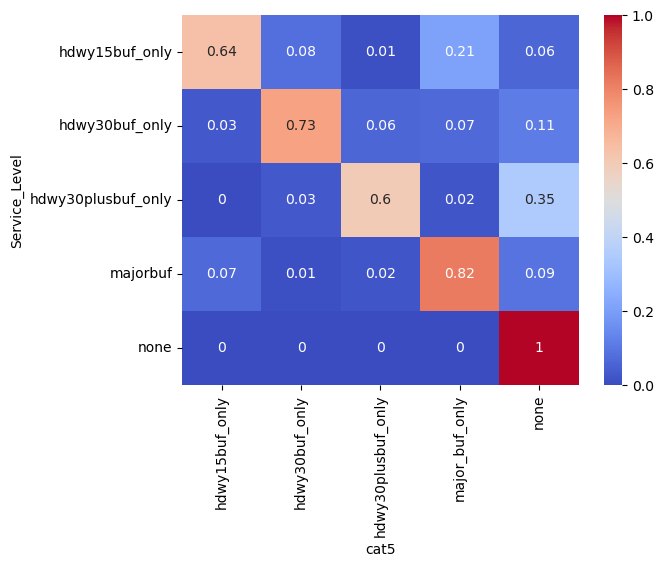

In [160]:
def pct(x): return x/x.sum()

mine_vs_bobbys = mine_vs_bobbys_fbp.groupby(['Service_Level', 'cat5']).area.sum(
).groupby(level=0, observed=True).apply(pct).round(2).unstack()

# While the diagonal is clearly there, there are important differences. Why?
# Turns out there are data source differences between the 2000 version and the one on AGOL now. Unclear why.
sns.heatmap(mine_vs_bobbys, cmap='coolwarm', annot=True)

## Step 2 - relate transit proximities to parcels (before adding any run specific data)

In [161]:
def classify_parcels(parcels_geo, transit_areas, scenario='current'):

    logger.info(f'Joining transit areas ({scenario}) to parcels')

    # core assignment, per sjoin
    p10_x_transit_areas = gpd.sjoin(parcels_geo, transit_areas)

    # check for unassigned
    unassigned_parcel_ids = set(
        parcels_geo.PARCEL_ID)-set(p10_x_transit_areas.PARCEL_ID)

    logger.info(
        f'There were {len(unassigned_parcel_ids)} parcels without an assignment to a transit area.\nWe assign to nearest area.')

    p10_x_transit_areas_remainder = gpd.sjoin_nearest(parcels_geo.query(
        'PARCEL_ID.isin(@unassigned_parcel_ids)'), transit_areas)

    # combine the two
    combo_assignments = pd.concat(
        [p10_x_transit_areas, p10_x_transit_areas_remainder])

    if (combo_assignments.PARCEL_ID.value_counts().sort_values() > 1).any():

        # if there are parcel duplicates - get the fist classification
        mapping = combo_assignments.groupby(
            'PARCEL_ID').cat5.first()
    else:
        # return the original mapping

        mapping = combo_assignments.set_index('PARCEL_ID').cat5

    return mapping

In [162]:
p10_x_transit_area_np = classify_parcels(p10_topofix_pt, transit_areas_np_dissolved, 'np')

03/20/2024 03:43:44 PM - INFO - Joining transit areas (np) to parcels
03/20/2024 04:10:52 PM - INFO - There were 72 parcels without an assignment to a transit area.
We assign to nearest area.


In [163]:
p10_x_transit_area_fbp = classify_parcels(p10_topofix_pt, transit_areas_fbp_dissolved, 'fbp')

03/20/2024 04:10:54 PM - INFO - Joining transit areas (fbp) to parcels
03/20/2024 04:40:10 PM - INFO - There were 72 parcels without an assignment to a transit area.
We assign to nearest area.


In [164]:
p10_x_transit_area_current = classify_parcels(p10_topofix_pt, transit_areas_current_dissolved, 'current')

03/20/2024 04:40:12 PM - INFO - Joining transit areas (current) to parcels
03/20/2024 05:12:25 PM - INFO - There were 72 parcels without an assignment to a transit area.
We assign to nearest area.


In [165]:
p10_x_transit_area_np.value_counts()

none                  845920
major_buf_only        420958
hdwy30buf_only        303060
hdwy30plusbuf_only    233137
hdwy15buf_only        153132
Name: cat5, dtype: int64

In [166]:
p10_x_transit_area_fbp.value_counts()

none                  820406
major_buf_only        504435
hdwy30buf_only        277357
hdwy30plusbuf_only    228205
hdwy15buf_only        125804
Name: cat5, dtype: int64

In [167]:
p10_x_transit_area_current.value_counts()

none                  845931
major_buf_only        419798
hdwy30buf_only        303570
hdwy30plusbuf_only    233776
hdwy15buf_only        153132
Name: cat5, dtype: int64

## Step 3 load run data and classify based on parcel_id


## Step 4: run the summaries
Note that we want to do the proper matching:
* 2015 should always be "current"
* 2050 blueprint should be matched with 2050 blueprint transit buffers
* 2050 no project should be matched with 2050 no project transit buffers

We are looking for output as follows [metrics_proximity.csv](https://mtcdrive.app.box.com/file/837349294434)


In [168]:
metrics_proximity_target_schema = pd.read_csv(
    '/Users/aolsen/Box/Horizon and Plan Bay Area 2050/Equity and Performance/7_Analysis/Metrics/Metrics_Outputs_FinalBlueprint/Intermediate Metrics/Archive Draft Plan Mar 2021/metrics_proximity.csv')
schema_iteration_vars = ['Service_Level', 'year',
                         'modelrunID', 'transit', 'area', 'blueprint']
# metrics_proximity_target_schema.groupby(schema_iteration_vars).size().unstack('modelrunID')

In [169]:
transit_scenario_crosswalk = {'trn_cur_cat5': p10_x_transit_area_current,
                              'trn_fp_cat5': p10_x_transit_area_fbp,
                              'trn_np_cat5': p10_x_transit_area_np}

In [170]:
def col_values(s, colname):
    #msg = f'values for {colname}\n n{s.value_counts()}'
    msg2 = f'{colname} records with no value assigned: {len(s[s.isna()])}'
    #logger.info(msg)
    logger.info(msg2)
    
col_values(parcel_x_tracts.tract10,'trt')

03/20/2024 05:14:29 PM - INFO - trt records with no value assigned: 17


In [172]:
def summarize_parcels(year, transit_scenario):

    parcel_output = pd.read_csv(parcel_file, engine='python')

    logger.info('  Read {} rows'.format(len(parcel_output)))

    # keep essential columns
#     parcel_output.drop(['geom_id', 'total_job_spaces', 'zoned_du',
#                         'zoned_du_underbuild', 'zoned_du_underbuild_nodev', 'first_building_type'], axis=1, inplace=True)
    logger.info("Head:\n{}".format(parcel_output.head()))

    val_cols = ['totemp', 'RETEMPN', 'MWTEMPN', 'tothh']

    for col in val_cols:
        parcel_output[col] = parcel_output[col].fillna(0).round(0).astype(int)

    ####################################################
    # add tractids, tazs to parcels

    # vintage 2010
    parcel_output['tract10'] = parcel_output.parcel_id.map(
        parcel_x_tracts.set_index('parcel_id').tract10.map(lambda x: f'{x:011.0f}'))
    col_values(parcel_output['tract10'], 'tract10')

    # vintage 2020
    parcel_output['tract20'] = parcel_output.parcel_id.map(
        parcel_x_tracts.set_index('parcel_id').tract20.map(lambda x: f'{x:011.0f}'))
    col_values(parcel_output['tract20'], 'tract20')

    # add TAZs
    parcel_output['taz'] = parcel_output.parcel_id.map(
        parcel_x_taz.set_index('PARCEL_ID').ZONE_ID)
    col_values(parcel_output['taz'], 'taz')

    ####################################################

    # add area type based on the just assigned taz
    parcel_output['area_type'] = parcel_output.taz.map(taz_x_areatype)
    col_values(parcel_output['area_type'], 'area_type')

    # add epc (RTP2021 version) to parcels using tract10
    parcel_output['epc21'] = parcel_output.tract10.map(
        tract_epc21_file.set_index('geoid10').epc_class.fillna('Not EPC'))
    col_values(parcel_output['epc21'], 'epc21')

    parcel_output['is_epc21'] = parcel_output.epc21 != 'Not EPC'
    col_values(parcel_output['is_epc21'], 'is_epc21')

    # add epc (RTP2025 version) to parcels using tract10
    parcel_output['epc24'] = parcel_output.tract20.map(
        tract_epc24_file.set_index('geoid20').epc_class.fillna('Not EPC'))
    col_values(parcel_output['epc24'], 'epc24')

    parcel_output['is_epc24'] = parcel_output.epc24 != 'Not EPC'
    col_values(parcel_output['is_epc24'], 'is_epc24')

    # add hra23 to parcels using tract10
    parcel_output['hra23'] = parcel_output.tract20.map(tract_hra_2023)
    col_values(parcel_output['hra23'], 'hra23')

    parcel_output['is_hra23'] = parcel_output.hra23.isin(
        ["High Resource", "Highest Resource"])
    col_values(parcel_output['is_hra23'], 'is_hra23')

    # add hra19 to parcels using tract10
    parcel_output['hra19'] = parcel_output.tract20.map(tract_hra_2023)
    col_values(parcel_output['hra19'], 'hra19')

    parcel_output['is_hra19'] = parcel_output.hra19.isin(
        ["High Resource", "Highest Resource"])
    col_values(parcel_output['is_hra19'], 'is_hra19')

    # map the cat5 service level names to more descriptive ones used in Tableau
    parcel_output['service_level'] = parcel_output.parcel_id.map(
        transit_scenario_crosswalk[transit_scenario])
    col_values(parcel_output['service_level'], 'service_level')

    service_level_map = {'none': 'No_Fixed_Route_Transit',
                         'hdwy30plusbuf_only': 'Bus_31plus_min',
                         'hdwy30buf_only': 'Bus_15_30min',
                         'hdwy15buf_only': 'Bus_<15min',
                         'major_buf_only': 'Major_Transit_Stop'}

    parcel_output['Service_Level'] = parcel_output['service_level'].map(
        service_level_map)
    col_values(parcel_output['Service_Level'], 'Service_Level')

    def groupby_summaries(df, group_vars):

        grp_summary = (df
                       .groupby(group_vars)
                       .agg({'tothh': 'sum', 'hhq1': 'sum',
                             'totemp': 'sum', 'RETEMPN': 'sum',
                             'MWTEMPN': 'sum'})
                       )

        grp_summary_shares = grp_summary.div(
            grp_summary.sum()).round(3)

        grp_summary_combo = pd.concat([grp_summary,
                                       grp_summary_shares.add_suffix('_share')
                                       ], axis=1
                                      )
        return grp_summary_combo

    container = {}

    summary_servicelevel = groupby_summaries(
        parcel_output, ['Service_Level'])

    summary_servicelevel_epc = groupby_summaries(
        parcel_output, ['is_epc24', 'Service_Level'])

    summary_servicelevel_hra = groupby_summaries(
        parcel_output, ['is_hra23', 'Service_Level'])

    summary_servicelevel_areatype = groupby_summaries(
        parcel_output, ['area_type', 'Service_Level'])

    container['Region'] = pd.concat([summary_servicelevel], keys=['reg'])
    container['CoCs'] = summary_servicelevel_epc
    container['HRAs'] = summary_servicelevel_hra
    container['area_type'] = summary_servicelevel_areatype

    return pd.concat(container)


parcel_output_summary = summarize_parcels(2050, 'trn_fp_cat5')

NameError: name 'parcel_file' is not defined

In [588]:
parcel_output_summary

tothh      hhq1   totemp  \
                   Service_Level                                        
Region    reg      Bus_15_30min             446593   58616.0   700044   
                   Bus_31plus_min           471834   51835.0   711485   
                   Bus_<15min               258283   63388.0   354708   
                   Major_Transit_Stop      1970302  748626.0  2780424   
                   No_Fixed_Route_Transit   894545   87186.0   860152   
CoCs      False    Bus_15_30min             367240   44644.0   601227   
                   Bus_31plus_min           403813   40009.0   639696   
                   Bus_<15min               207563   49315.0   276238   
                   Major_Transit_Stop      1454362  522000.0  1948118   
                   No_Fixed_Route_Transit   828164   73727.0   761579   
          True     Bus_15_30min              79353   13972.0    98817   
                   Bus_31plus_min            68021   11826.0    71789   
                   Bus_<15min                50720   14073.0    78470   
                   Major_Transit_Stop       515940  226626.0   832306   
                   No_Fixed_Route_Transit    66381   13459.0    98573   
HRAs      False    Bus_15_30min             259194   34040.0   466649   
                   Bus_31plus_min           354388   40994.0   554385   
                   Bus_<15min               149294   36733.0   237975   
                   Major_Transit_Stop      1438364  573839.0  2202281   
                   No_Fixed_Route_Transit   547863   61534.0   650844   
          True     Bus_15_30min             187399   24576.0   233395   
                   Bus_31plus_min           117446   10841.0   157100   
                   Bus_<15min               108989   26655.0   116733   
                   Major_Transit_Stop       531938  174787.0   578143   
                   No_Fixed_Route_Transit   346682   25652.0   209308   
area_type rural    Bus_15_30min              17318    1988.0    17945   
                   Bus_31plus_min            63400    6042.0    72234   
                   Bus_<15min                 4044     786.0     9187   
                   Major_Transit_Stop        19812   10865.0    17863   
                   No_Fixed_Route_Transit   204304   14105.0   185509   
          suburban Bus_15_30min             226352   23356.0   377923   
                   Bus_31plus_min           262956   23132.0   311539   
                   Bus_<15min                87872   18833.0   122746   
                   Major_Transit_Stop       284373  104890.0   275473   
                   No_Fixed_Route_Transit   478465   42933.0   380645   
          urban    Bus_15_30min             202923   33272.0   304176   
                   Bus_31plus_min           145478   22661.0   327712   
                   Bus_<15min               166367   43769.0   222775   
                   Major_Transit_Stop      1666117  632871.0  2487088   
                   No_Fixed_Route_Transit   211776   30148.0   293998   

                                           RETEMPN  MWTEMPN  tothh_share  \
                   Service_Level                                           
Region    reg      Bus_15_30min              71128    94200        0.111   
                   Bus_31plus_min            56763    98146        0.117   
                   Bus_<15min                46591    39294        0.064   
                   Major_Transit_Stop       221462   192787        0.488   
                   No_Fixed_Route_Transit    45611   183222        0.221   
CoCs      False    Bus_15_30min              57878    82734        0.091   
                   Bus_31plus_min            49172    87999        0.100   
                   Bus_<15min                39401    27932        0.051   
                   Major_Transit_Stop       164327   148944        0.360   
                   No_Fixed_Route_Transit    40895   152916        0.205   
          True     Bus_15_30min              13250    11466       

In [602]:
# copying in the code from the metrics script for reference - 
# it is mainly an accounting script in the sense that the outputs are really coming from Bobby's scripts
# and by extension this notebook's scripts - share of households, etc by different transit service geographes

def calculate_Connected1_proximity(runid, year, dbp, transitproximity_df, metrics_dict):

    metric_id = "C1"

    for area_type in ['Region', 'CoCs', 'HRAs', 'rural', 'suburban', 'urban']:
        # households
        metrics_dict[runid, metric_id, 'transitproximity_majorstop_shareof_tothh_%s' % area_type, year, dbp] = transitproximity_df.loc[(transitproximity_df['Service_Level'] == "Major_Transit_Stop")
                                                                                                                                       & (transitproximity_df['year'] == int(year))
                                                                                                                                       & (transitproximity_df['blueprint'].str.contains(dbp))
                                                                                                                                       & (transitproximity_df['area'] == area_type), 'tothh_share'].sum()
        metrics_dict[runid, metric_id, 'transitproximity_majorstop_shareof_hhq1_%s' % area_type, year, dbp] = transitproximity_df.loc[(transitproximity_df['Service_Level'] == "Major_Transit_Stop")
                                                                                                                                      & (transitproximity_df['year'] == int(year))
                                                                                                                                      & (transitproximity_df['blueprint'].str.contains(dbp))
                                                                                                                                      & (transitproximity_df['area'] == area_type), 'hhq1_share'].sum()
        # jobs
        metrics_dict[runid, metric_id, 'transitproximity_majorstop_shareof_totemp_%s' % area_type, year, dbp] = transitproximity_df.loc[(transitproximity_df['Service_Level'] == "Major_Transit_Stop")
                                                                                                                                        & (transitproximity_df['year'] == int(year))
                                                                                                                                        & (transitproximity_df['blueprint'].str.contains(dbp))
                                                                                                                                        & (transitproximity_df['area'] == area_type), 'totemp_share'].sum()
        metrics_dict[runid, metric_id, 'transitproximity_majorstop_shareof_RETEMPNjobs_%s' % area_type, year, dbp] = transitproximity_df.loc[(transitproximity_df['Service_Level'] == "Major_Transit_Stop")
                                                                                                                                             & (transitproximity_df['year'] == int(year))
                                                                                                                                             & (transitproximity_df['blueprint'].str.contains(dbp))
                                                                                                                                             & (transitproximity_df['area'] == area_type), 'RETEMPN_share'].sum()
        metrics_dict[runid, metric_id, 'transitproximity_majorstop_shareof_MWTEMPNjobs_%s' % area_type, year, dbp] = transitproximity_df.loc[(transitproximity_df['Service_Level'] == "Major_Transit_Stop")
                                                                                                                                             & (transitproximity_df['year'] == int(year)) & (transitproximity_df['blueprint'].str.contains(dbp))
                                                                                                                                             & (transitproximity_df['area'] == area_type), 'MWTEMPN_share'].sum()

In [266]:
metrics = pd.read_csv('/Users/aolsen/Box/Horizon and Plan Bay Area 2050/Equity and Performance/7_Analysis/Metrics/Metrics_Outputs_FinalBlueprint/metrics.csv')
metrics.loc[(metrics.modelrunID.str.contains("PlusCrossing"))&(metrics['name'].str.contains('transitprox'))]

,modelrunID,metric,name,year,blueprint,value
2640,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_tothh_Region,2050,Plus,0.49
2641,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_hhq1_Region,2050,Plus,0.74
2642,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_totemp_Region,2050,Plus,0.51
2643,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_RETEMPNjobs...,2050,Plus,0.5
2644,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_MWTEMPNjobs...,2050,Plus,0.32
2645,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_tothh_CoCs,2050,Plus,0.68
2646,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_hhq1_CoCs,2050,Plus,0.82
2647,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_totemp_CoCs,2050,Plus,0.66
2648,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_RETEMPNjobs...,2050,Plus,0.61
2649,2050_TM152_FBP_PlusCrossing_24,C1,transitproximity_majorstop_shareof_MWTEMPNjobs...,2050,Plus,0.4


In [263]:
metrics.query('blueprint=="NoProject" & name=="deed_restricted_total"')

,modelrunID,metric,name,year,blueprint,value
168,EIR runs/Baseline Large (s25) runs/NP_v8_FINAL...,A2,deed_restricted_total,2050,NoProject,574252
169,EIR runs/Baseline Large (s25) runs/NP_v8_FINAL...,A2,deed_restricted_total,2015,NoProject,121292


In [264]:
# metrics[metrics.name.str.lower().str.contains('deed')].set_index(['modelrunID','year','blueprint','name']).value.unstack([0,2]).loc[2050].T.to_clipboard()

In [267]:
metrics_proximity_target_schema.query('blueprint=="Plus" & year==2050 & transit=="trn_fp_cat5" & area=="Region"') #& area=="CoCs"

,Service_Level,tothh,hhq1,totemp,RETEMPN,MWTEMPN,tothh_share,hhq1_share,totemp_share,RETEMPN_share,MWTEMPN_share,year,modelrunID,transit,area,blueprint
165,Bus_15_30min,241445,30886,415937,36569,68977,0.06,0.03,0.08,0.08,0.11,2050,Final Blueprint runs/Final Blueprint (s24)/BAU...,trn_fp_cat5,Region,Plus
166,Bus_31plus_min,281742,31131,379888,31432,60476,0.07,0.03,0.07,0.07,0.10,2050,Final Blueprint runs/Final Blueprint (s24)/BAU...,trn_fp_cat5,Region,Plus
167,Bus_<15min,786845,127837,1083359,115284,114261,0.19,0.13,0.20,0.26,0.19,2050,Final Blueprint runs/Final Blueprint (s24)/BAU...,trn_fp_cat5,Region,Plus
168,Major_Transit_Stop,1971306,749222,2785232,221557,194184,0.49,0.74,0.51,0.50,0.32,2050,Final Blueprint runs/Final Blueprint (s24)/BAU...,trn_fp_cat5,Region,Plus
169,No_Fixed_Route_Transit,761974,70889,744044,36717,169760,0.19,0.07,0.14,0.08,0.28,2050,Final Blueprint runs/Final Blueprint (s24)/BAU...,trn_fp_cat5,Region,Plus


'aolsen'

In [207]:
# Urbansim Setup
urbansim_run_location = f'/Users/{user}/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/'
# keep DBP for future
us_2050_DBP_Final = 'Draft Blueprint runs/Blueprint Plus Crossing (s23)/v1.7.1- FINAL DRAFT BLUEPRINT/run98'
us_2050_FBP_Final = 'Final Blueprint runs/Final Blueprint (s24)/BAUS v2.25 - FINAL VERSION/run182'
us_2050_NP_EIR = 'EIR runs/Baseline Large (s25) runs/NP_v8_FINAL/run314'
us_2050_ALT1_EIR = 'EIR runs/Alt1 (s26) runs/Alt1_v3_test_far_tiers_FINAL_EIR_ALT/run375'
us_2050_ALT2_EIR = 'EIR runs/Alt2 (s28) runs/Alt2_v1_FINAL_EIR_ALT/run374'

list_us_runid = [us_2050_NP_EIR, us_2050_ALT1_EIR, us_2050_ALT2_EIR,
                 us_2050_FBP_Final]  # , us_2050_FBP_Final, us_2050_DBP_Final]
list_us_runid

['EIR runs/Baseline Large (s25) runs/NP_v8_FINAL/run314',
 'EIR runs/Alt1 (s26) runs/Alt1_v3_test_far_tiers_FINAL_EIR_ALT/run375',
 'EIR runs/Alt2 (s28) runs/Alt2_v1_FINAL_EIR_ALT/run374',
 'Final Blueprint runs/Final Blueprint (s24)/BAUS v2.25 - FINAL VERSION/run182']

In [225]:
model_year=2050
us_2050_FBP_Final = 'EIR runs/Baseline Large (s25) runs/NP_v8_FINAL'
run_id = 'run314'

parcels_np50 = pd.read_csv(os.path.join(urbansim_run_location,us_2050_FBP_Final,'{}_parcel_data_{}.csv'.format(run_id,model_year)))

In [234]:
(parcels_np50.deed_restricted_units.sum()
 / parcels_np50.residential_units.sum())

0.06220370791735696

In [252]:
parcels_np50.residential_units.sum()
parcels_np50.deed_restricted_units.sum()

264630.0

In [213]:
model_year=2050
us_2050_FBP_Final = 'Final Blueprint runs/Final Blueprint (s24)/BAUS v2.25 - FINAL VERSION'
run_id = 'run182'

parcels_pba50 = pd.read_csv(os.path.join(urbansim_run_location,us_2050_FBP_Final,'{}_parcel_data_{}_UBI.csv'.format(run_id,model_year)))

In [250]:
parcels_pba50.deed_restricted_units.sum()/parcels_pba50.residential_units.sum()
parcels_pba50.residential_units.sum()

4259618.0

In [268]:
parcels_pba50.deed_restricted_units.sum()

1083815.0

In [173]:
def parcel_file_name(scenario, year):

    for model_year in (2015, 2050):
        if model_year == 2050:
            if us_runid == us_2050_FBP_Final:
                parcel_file = urbansim_runid + \
                    '_parcel_data_{}_UBI.csv'.format(model_year)
            else:
                parcel_file = urbansim_runid + \
                    '_parcel_data_{}.csv'.format(model_year)
        else:
            parcel_file = urbansim_runid + \
                '_parcel_data_{}.csv'.format(model_year)
    urbansim_runid = os.path.join(urbansim_run_location, us_runid)

    return urbansim_runid

In [ ]:
def load_pba_parcel_data(scenario):

    column_map = {'tothh_share', 'hhq1_share',
                  'totemp_share', 'RETEMPN_share', 'MWTEMPN_share'}

    for model_year in (2015, 2050):
        if model_year == 2050:
            if us_runid == us_2050_FBP_Final:
                parcel_file = urbansim_runid + \
                    '_parcel_data_{}_UBI.csv'.format(model_year)
            else:
                parcel_file = urbansim_runid + \
                    '_parcel_data_{}.csv'.format(model_year)
        else:
            parcel_file = urbansim_runid + \
                '_parcel_data_{}.csv'.format(model_year)
        logger.info('Reading {} parcel data from {}'.format(
            model_year, parcel_file))
        parcel_output = pd.read_csv(parcel_file, engine='python')

        logger.info('  Read {} rows'.format(len(parcel_output)))

        # keep essential columns
        parcel_output.drop(['geom_id', 'total_job_spaces', 'zoned_du',
                            'zoned_du_underbuild', 'zoned_du_underbuild_nodev', 'first_building_type'], axis=1, inplace=True)
        logger.info("Head:\n{}".format(parcel_output.head()))

        parcel_output['totemp'] = parcel_output['totemp'].fillna(0)
        parcel_output['totemp'] = parcel_output['totemp'].round(
            0).astype('int')
        parcel_output['RETEMPN'] = parcel_output['RETEMPN'].fillna(0)
        parcel_output['RETEMPN'] = parcel_output['RETEMPN'].round(
            0).astype('int')
        parcel_output['MWTEMPN'] = parcel_output['MWTEMPN'].fillna(0)
        parcel_output['MWTEMPN'] = parcel_output['MWTEMPN'].round(
            0).astype('int')

In [ ]:
['year','transit','modelrunID','tothh_share'  ,'hhq1_share'  ,'totemp_share' ,'RETEMPN_share','MWTEMPN_share','modelrunID']

        prox_sdf_taz['tothh_share'  ] = round(prox_sdf_taz.tothh  / prox_sdf_taz.tothh.sum(),  2)
        prox_sdf_taz['hhq1_share'   ] = round(prox_sdf_taz.hhq1   / prox_sdf_taz.hhq1.sum()  , 2)
        prox_sdf_taz['totemp_share' ] = round(prox_sdf_taz.totemp / prox_sdf_taz.totemp.sum(), 2)
        prox_sdf_taz['RETEMPN_share'] = round(prox_sdf_taz.RETEMPN/prox_sdf_taz.RETEMPN.sum(), 2)
        prox_sdf_taz['MWTEMPN_share'] = round(prox_sdf_taz.MWTEMPN/prox_sdf_taz.MWTEMPN.sum(), 2)
        prox_sdf_taz['year'] = str(model_year)
        prox_sdf_taz['modelrunID'] = us_runid
        prox_sdf_taz['transit'] = transit_feature

# Sandbox

In [ ]:
def create_multiple_transit_areas_old(transit_stop_gdf, scenario='current', write_to_disk=False):

    logger.info(
        f"Running create_transit_areas function for variant: {scenario}")
    logger.info(f"transit_stop_gdf has shape: {transit_stop_gdf.shape}")

    buf_dist_half = .5

    qry_str_major = "(major_stop == 1)"
    logger.info(
        f"Subsetting stops to {qry_str_major}, and adding {buf_dist_half} mile buffer")
    major_buf = subset_and_buffer(
        transit_stop_gdf, qry_str_major, buf_dist_half)

    buf_dist_qtr = .25

    qry_str_hdwy_lt15 = "(am_av_hdwy <= 15) & (pm_av_hdwy <= 15)"
    logger.info(
        f"Subsetting stops to {qry_str_hdwy_lt15}, and adding {buf_dist_qtr} mile buffer")
    hdwy15_buf = subset_and_buffer(
        transit_stop_gdf, qry_str_hdwy_lt15, buf_dist_qtr)

    qry_str_hdwy_15_to_30 = "( am_av_hdwy >15 ) & (am_av_hdwy <=30) & ( pm_av_hdwy >15 ) & (pm_av_hdwy <=30)  "
    logger.info(
        f"Subsetting stops to {qry_str_hdwy_15_to_30}, and adding {buf_dist_qtr} mile buffer")
    hdwy30_buf = subset_and_buffer(
        transit_stop_gdf, qry_str_hdwy_15_to_30, buf_dist_qtr)

    qry_str_hdwy_gt30 = "(am_av_hdwy > 30) | (pm_av_hdwy > 30)"
    logger.info(
        f"Subsetting stops to {qry_str_hdwy_gt30}, and adding {buf_dist_qtr} mile buffer")
    hdwy30plus_buf = subset_and_buffer(
        transit_stop_gdf, qry_str_hdwy_gt30, buf_dist_qtr)

    ## Union and classify

    # these are the frames we are interested in for the union. We will denote in the
    # union process whether a geometry is covered by a particular spatial frame

    # the ordering here matters - reflecting a hierarchy of interest: we will use
    # to classify areas based on the highest order category in this list
    source_frames_ordered = ['major_buf', 'hdwy15buf', 'hdwy30buf', 'hdwy30plusbuf',
                             'reg']

    # geopandas can only handle two input layers at a time when unioning. We do it step-wise.

    logger.info(
        f"Beginning a series of unions, to get all buffers to fully define regional space")

    logger.info(f"Unioning hdwy15_buf and hdwy30_buf")

    # row_ids are in the source frames; we disambiguate to denote whether a particular
    # area is "covered" by either of the source files.
    # As we are dealing with dissolved geometries for the source geometries, it means
    # each source DF has just 1 row with multipart geoms - and that row_id then just
    # has the index value of 0 carried forward. So in the resulting union, a row_id value
    # of 0 means that a given area was represented in the relevant source dataframe;
    # a value of NaN means there was no corresponding match for a particular dataframe
    # this is useful for classifying areas based on the "source" buffer geometries present
    # for a particular location

    union_1 = gpd.overlay(hdwy15_buf, hdwy30_buf, how='union').reset_index().rename(
        columns={'index': 'df_1', 'rowid_1': 'hdwy15buf', 'rowid_2': 'hdwy30buf'})

    logger.info(f'union_1 shape: {union_1.shape}')

    logger.info(f"Adding hdwy30plus_buf...")
    union_2 = gpd.overlay(union_1, hdwy30plus_buf, how='union').reset_index().rename(
        columns={'index': 'df_2', 'rowid': 'hdwy30plusbuf'})

    # return union_1,hdwy15_buf, hdwy30_buf,union_2,hdwy30plus_buf

    logger.info(f'union_2 shape: {union_2.shape}')

    logger.info(f"Adding major stops buffer...")

    union_3 = gpd.overlay(union_2, major_buf, how='union').reset_index(
    ).rename(columns={'index': 'df_3', 'rowid': 'major_buf'})

    logger.info(f'union_3 shape: {union_3.shape}')
    logger.info(
        f"Adding regional boundary so we can get wall to wall coverage")

    # added small (here 10cm) geometry simplification to avoid a TopologyException: found non-noded intersection
    union_3['geometry'] = union_3.simplify(.1)

    union_4 = gpd.overlay(union_3, region_bdry, how='union').reset_index(
    ).rename(columns={'index': 'df_4', 'name': 'reg'})
    logger.info(f'union_4 shape: {union_4.shape}')
    logger.info('-'*80)
    logger.info(f'union_4 head: {union_4.head().T}')
    logger.info('-'*80)

    # except:
#     logger.error("Traceback info:\n{}\nError Info:\n{}".format(
#         'unions', str(sys.exc_info()[1])))

    # fill nas with -1 - those are values where a particular transit buffer layer doesn't cover something
    union_4 = union_4.fillna(-1)

    # we need boolean values to grab the group names
    logger.info(
        f"With the full region unioned, we now focus on classifying the different combinations")
    union_4[source_frames_ordered] = union_4[source_frames_ordered].replace(
        {0: True, -1: False})

    # get an integer encoding the unique combination of union components.
    # e.g. some areas will be in the buffer of a major stop and a 15 min headway
    # but not a 30 min headway. Others will only be in a 15 min headway buffer
    # we group areas that share the same combination. We then use that in the
    # naming of those groups just downstream; naming them based on
    # the boolean True values (indicating a particular buffer is represented)

    union_4['ngroup'] = union_4.groupby(source_frames_ordered).ngroup()

    # Then, for each combination of overlapping areas, get the most important
    # where rail (major stop) trumps 15min headway; 15min headway trumps 30 min headway etc

    union_4['cat5'] = union_4.ngroup.map(union_4.groupby(['ngroup'])[source_frames_ordered].apply(
        get_combination_names_hierarchy))

    # get the full string list of components in any given unioned area
    union_4['ngroup_desc'] = union_4.ngroup.map(union_4.groupby(['ngroup'])[source_frames_ordered].apply(
        get_combination_names))

    if write_to_disk:
        union_4.to_file(f'/Users/aolsen/Downloads/union_4_{scenario}.geojson',driver='GeoJSON')

    return union_4, union_4.dissolve('cat5', as_index=False)[['cat5', 'geometry']]

In [174]:
list_us_runid

NameError: name 'list_us_runid' is not defined

In [82]:
# Bring in urbansim results
all_prox = pd.DataFrame()
taz_prox = pd.DataFrame()

for us_runid in list_us_runid:
    logger.info("")
    logger.info("==== Processing UrbanSim run {} ====".format(us_runid))
    urbansim_runid = os.path.join(urbansim_run_location, us_runid)

    for model_year in (2015, 2050):
        if model_year == 2050:
            if us_runid == us_2050_FBP_Final:
                parcel_file = urbansim_runid + \
                    '_parcel_data_{}_UBI.csv'.format(model_year)
            else:
                parcel_file = urbansim_runid + \
                    '_parcel_data_{}.csv'.format(model_year)
        else:
            parcel_file = urbansim_runid + \
                '_parcel_data_{}.csv'.format(model_year)
        logger.info('Reading {} parcel data from {}'.format(
            model_year, parcel_file))
        parcel_output = pd.read_csv(parcel_file, engine='python')

        logger.info('  Read {} rows'.format(len(parcel_output)))

        # keep essential columns
        parcel_output.drop(['geom_id', 'total_job_spaces', 'zoned_du',
                            'zoned_du_underbuild', 'zoned_du_underbuild_nodev', 'first_building_type'], axis=1, inplace=True)
        logger.info("Head:\n{}".format(parcel_output.head()))

        parcel_output['totemp'] = parcel_output['totemp'].fillna(0)
        parcel_output['totemp'] = parcel_output['totemp'].round(
            0).astype('int')
        parcel_output['RETEMPN'] = parcel_output['RETEMPN'].fillna(0)
        parcel_output['RETEMPN'] = parcel_output['RETEMPN'].round(
            0).astype('int')
        parcel_output['MWTEMPN'] = parcel_output['MWTEMPN'].fillna(0)
        parcel_output['MWTEMPN'] = parcel_output['MWTEMPN'].round(
            0).astype('int')

        # save as table in gdb
#         parcel_table = os.path.join(arcpy.env.workspace, "parcel_table")
#         if arcpy.Exists(parcel_table): arcpy.management.Delete(parcel_table)

#         parcel_array = np.array(np.rec.fromrecords(parcel_output.values))
#         parcel_array.dtype.names = tuple(parcel_output.dtypes.index.tolist())
#         arcpy.da.NumPyArrayToTable(parcel_array, parcel_table)
#         logger.info("Saved to {} in {}".format(parcel_table, arcpy.env.workspace))

        # convert to point feature class in GDB
#         if arcpy.Exists('parcel_fc'): arcpy.management.Delete('parcel_fc')
#         arcpy.management.XYTableToPoint(in_table=parcel_table, out_feature_class='parcel_fc',x_field='x',y_field='y')
#         logger.info("Saved to {} in {}".format('parcel_fc', arcpy.env.workspace))

03/18/2024 05:18:21 PM - INFO - 
03/18/2024 05:18:21 PM - INFO - ==== Processing UrbanSim run EIR runs/Baseline Large (s25) runs/NP_v8_FINAL/run314 ====
03/18/2024 05:18:21 PM - INFO - Reading 2015 parcel data from /Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/EIR runs/Baseline Large (s25) runs/NP_v8_FINAL/run314_parcel_data_2015.csv
03/18/2024 05:18:52 PM - INFO -   Read 1956212 rows
03/18/2024 05:18:52 PM - INFO - Head:
   parcel_id           x          y         fbpchcat                  juris  \
0     229116 -121.795620  37.655379   NANAHRADISNAin              livermore   
1     244166 -121.713004  37.717277    NAtra3DISNAin              livermore   
2     202378 -122.014199  37.655260       NANANANAin                hayward   
3    2004420 -122.771868  38.727893  NANAHRADISNAout  unincorporated_sonoma   
4     340332 -121.974508  37.546277   NANAHRADISNAin                fremont   

   hhq1  hhq2  hhq3  hhq4  tothh  ...  preserved_units  inclusionar

03/18/2024 05:20:48 PM - INFO -   Read 1956212 rows
03/18/2024 05:20:49 PM - INFO - Head:
   parcel_id          y           x                  juris  \
0     229116  37.655379 -121.795620              livermore   
1     244166  37.717277 -121.713004              livermore   
2     202378  37.655260 -122.014199                hayward   
3    2004420  38.727893 -122.771868  unincorporated_sonoma   
4     340332  37.546277 -121.974508                fremont   

                            eirzoningmodcat  hhq1  hhq2  hhq3  hhq4  tothh  \
0               livermoreNANAHRADISNANAinNA   NaN   NaN   NaN   NaN    NaN   
1                livermoreNAtra3DISNANAinNA   NaN   NaN   NaN   NaN    NaN   
2                    haywardNANANANANAinres   7.0   4.0  10.0  10.0   31.0   
3  unincorporated_sonomaNANAHRADISNANAoutNA   NaN   NaN   NaN   NaN    NaN   
4                 fremontNANAHRADISNANAinNA   NaN   NaN   NaN   NaN    NaN   

   ...  preserved_units  inclusionary_units  subsidized_units  AGREM

In [ ]:
if model_year == 2015:
        # current
        transit_features = ['trn_cur_cat5']
    elif model_year == 2050:
        # no plan and blueprint
        transit_features = ['trn_np_cat5', 'trn_fp_cat5']

    for transit_feature in transit_features:

        logger.info('Summarizing {} parcel data proximity to {}'.format(
            model_year, transit_feature))
        log_workspace_contents(logger)

        try:
            logger.info("feature classes no paths")
            arcpy.SummarizeWithin_analysis(transit_feature, 'parcel_fc', 'prox', keep_all_polygons="KEEP_ALL",
                                            sum_fields=[['tothh', 'SUM'], ['hhq1','SUM'],['totemp','SUM'],['RETEMPN','SUM'],['MWTEMPN','SUM']])
            # hasn't worked, see comments below
            logger.info("SUCCESS")
        except:
            # Get the tool error messages
            msgs = arcpy.GetMessages(2)
            logger.error("Exception occured; msgs: {}".format(msgs))

            # Get the traceback object
            tb = sys.exc_info()[2]
            tbinfo = traceback.format_tb(tb)[0]

            # Concatenate information together concerning the error into a message string
            logger.error("Traceback info:\n{}\nError Info:\n{}".format(
                tbinfo, str(sys.exc_info()[1])))
            logger.error(
                "It's ok though -- we'll do this another way, but still trying the easy way")

        # Something related to arcpy.SummarizeWithin_analysis() is buggy
        # The following attempts have failed with
        # ERROR 000187: Only supports Geodatabase tables and feature classes
        # * use the method with feature layers as inputs, with full paths and without
        # * use the method with feature classes as inputs, with full paths and without
        # * call the short script below via subprocess
        # * copy feature classes to arcpy.env.scratchGDB and summarizeWithin there
        #
        # HOWEVER, after this script fails, running the following on the command line succeeds:
        #
        # >>> import arcpy
        # >>> arcpy.env.workspace='M:\Data\GIS layers\JobsHousingTransitProximity\workspace_2020_1007_1737.gdb'
        # >>> arcpy.SummarizeWithin_analysis('trn_cur_cat5', 'parcel_fc', 'prox', keep_all_polygons='KEEP_ALL', sum_fields=[['tothh','SUM'], ['hhq1','SUM'],['totemp','SUM'],['RETEMPN','SUM'],['MWTEMPN','SUM']])
        # <Result 'M:\\Data\\GIS layers\\JobsHousingTransitProximity\\workspace_2020_1007_1737.gdb\\prox'>
        # >>> prox_sdf = pd.DataFrame.spatial.from_featureclass('prox')
        #
        # so we'll summarize within ourselves and use spatial join instead
        if arcpy.Exists('parcel_fc_join_trn'):
            arcpy.management.Delete('parcel_fc_join_trn')
        logger.info("spatial joining parcel_fc with {}".format(transit_feature))
        arcpy.SpatialJoin_analysis(target_features='parcel_fc', join_features=transit_feature,
                                   out_feature_class='parcel_fc_join_trn')

        logger.info("spatial joining parcel_fc_join_trn with {}".format(taz))
        arcpy.SpatialJoin_analysis(target_features='parcel_fc_join_trn', join_features=taz,
                                   out_feature_class='parcel_fc_join_trn_taz')

        logger.info(
            "spatial joining parcel_fc_join_trn_taz with {}".format(tract))
        arcpy.SpatialJoin_analysis(target_features='parcel_fc_join_trn_taz', join_features=tract,
                                   out_feature_class='parcel_fc_join_trn_taz_tract')
        logger.info("    ...complete")

        prox_sdf_ba = pd.DataFrame.spatial.from_featureclass(
            'parcel_fc_join_trn_taz_tract')
        prox_sdf = prox_sdf_ba.groupby('Service_Level').agg({'tothh': 'sum', 'hhq1':'sum', 
                                                         'totemp': 'sum', 'RETEMPN':'sum',
                                                         'MWTEMPN': 'sum'}).reset_index()

        prox_sdf['tothh_share'  ] = round(prox_sdf.tothh  / prox_sdf.tothh.sum(),  2)
        prox_sdf['hhq1_share'   ] = round(prox_sdf.hhq1   / prox_sdf.hhq1.sum()  , 2)
        prox_sdf['totemp_share' ] = round(prox_sdf.totemp / prox_sdf.totemp.sum(), 2)
        prox_sdf['RETEMPN_share'] = round(prox_sdf.RETEMPN/prox_sdf.RETEMPN.sum(), 2)
        prox_sdf['MWTEMPN_share'] = round(prox_sdf.MWTEMPN/prox_sdf.MWTEMPN.sum(), 2)
        prox_sdf['year'] = str(model_year)
        prox_sdf['modelrunID'] = us_runid
        prox_sdf['transit'] = transit_feature
        prox_sdf['area'] = 'Region'

        logger.info("prox_sdf:\n{}".format(prox_sdf))
        all_prox = all_prox.append(prox_sdf)

        prox_sdf_epc = prox_sdf_ba[prox_sdf_ba.epc == 1]
        prox_sdf_epc = prox_sdf_epc.groupby('Service_Level').agg({'tothh': 'sum', 'hhq1':'sum', 
                                                         'totemp': 'sum', 'RETEMPN':'sum',
                                                         'MWTEMPN': 'sum'}).reset_index()

        prox_sdf_epc['tothh_share'  ] = round(prox_sdf_epc.tothh  / prox_sdf_epc.tothh.sum(),  2)
        prox_sdf_epc['hhq1_share'   ] = round(prox_sdf_epc.hhq1   / prox_sdf_epc.hhq1.sum()  , 2)
        prox_sdf_epc['totemp_share' ] = round(prox_sdf_epc.totemp / prox_sdf_epc.totemp.sum(), 2)
        prox_sdf_epc['RETEMPN_share'] = round(prox_sdf_epc.RETEMPN/prox_sdf_epc.RETEMPN.sum(), 2)
        prox_sdf_epc['MWTEMPN_share'] = round(prox_sdf_epc.MWTEMPN/prox_sdf_epc.MWTEMPN.sum(), 2)
        prox_sdf_epc['year'] = str(model_year)
        prox_sdf_epc['modelrunID'] = us_runid
        prox_sdf_epc['transit'] = transit_feature
        prox_sdf_epc['area'] = 'epcs'

        logger.info("prox_sdf_epc:\n{}".format(prox_sdf_epc))
        all_prox = all_prox.append(prox_sdf_epc)

        prox_sdf_hra = prox_sdf_ba[prox_sdf_ba.hra == 1]
        prox_sdf_hra = prox_sdf_hra.groupby('Service_Level').agg({'tothh': 'sum', 'hhq1':'sum', 
                                                         'totemp': 'sum', 'RETEMPN':'sum',
                                                         'MWTEMPN': 'sum'}).reset_index()

        prox_sdf_hra['tothh_share'  ] = round(prox_sdf_hra.tothh  / prox_sdf_hra.tothh.sum(),  2)
        prox_sdf_hra['hhq1_share'   ] = round(prox_sdf_hra.hhq1   / prox_sdf_hra.hhq1.sum()  , 2)
        prox_sdf_hra['totemp_share' ] = round(prox_sdf_hra.totemp / prox_sdf_hra.totemp.sum(), 2)
        prox_sdf_hra['RETEMPN_share'] = round(prox_sdf_hra.RETEMPN/prox_sdf_hra.RETEMPN.sum(), 2)
        prox_sdf_hra['MWTEMPN_share'] = round(prox_sdf_hra.MWTEMPN/prox_sdf_hra.MWTEMPN.sum(), 2)
        prox_sdf_hra['year'] = str(model_year)
        prox_sdf_hra['modelrunID'] = us_runid
        prox_sdf_hra['transit'] = transit_feature
        prox_sdf_hra['area'] = 'HRAs'

        logger.info("prox_sdf_hra:\n{}".format(prox_sdf_hra))
        all_prox = all_prox.append(prox_sdf_hra)

        logger.info("all_prox:\n{}".format(all_prox))

        prox_sdf_taz = prox_sdf_ba.groupby(['area_type', 'Service_Level']).agg({'tothh':'sum', 'hhq1':'sum', 
                                                         'totemp': 'sum', 'RETEMPN':'sum',
                                                         'MWTEMPN': 'sum'}).reset_index()

        prox_sdf_taz['tothh_share'  ] = round(prox_sdf_taz.tothh  / prox_sdf_taz.tothh.sum(),  2)
        prox_sdf_taz['hhq1_share'   ] = round(prox_sdf_taz.hhq1   / prox_sdf_taz.hhq1.sum()  , 2)
        prox_sdf_taz['totemp_share' ] = round(prox_sdf_taz.totemp / prox_sdf_taz.totemp.sum(), 2)
        prox_sdf_taz['RETEMPN_share'] = round(prox_sdf_taz.RETEMPN/prox_sdf_taz.RETEMPN.sum(), 2)
        prox_sdf_taz['MWTEMPN_share'] = round(prox_sdf_taz.MWTEMPN/prox_sdf_taz.MWTEMPN.sum(), 2)
        prox_sdf_taz['year'] = str(model_year)
        prox_sdf_taz['modelrunID'] = us_runid
        prox_sdf_taz['transit'] = transit_feature

        logger.info("prox_sdf:\n{}".format(prox_sdf_taz))
        taz_prox = taz_prox.append(prox_sdf_taz)

        logger.info("taz_prox:\n{}".format(taz_prox))

In [269]:
# union_1.to_file('/Users/aolsen/Downloads/union_1.geojson', driver='GeoJSON')
# union_2.to_file('/Users/aolsen/Downloads/union_2.geojson', driver='GeoJSON')
# union_3.to_file('/Users/aolsen/Downloads/union_3.geojson', driver='GeoJSON')
# union_4.to_file('/Users/aolsen/Downloads/union_4.geojson', driver='GeoJSON')

In [236]:
# hdwy15_buf.to_file(
#     '/Users/aolsen/Downloads/hdwy15_buf.geojson', driver='GeoJSON')
# hdwy30_buf.to_file(
#     '/Users/aolsen/Downloads/hdwy30_buf.geojson', driver='GeoJSON')
# hdwy30plus_buf.to_file(
#     '/Users/aolsen/Downloads/hdwy30plus_buf.geojson', driver='GeoJSON')
# major_buf.to_file(
#     '/Users/aolsen/Downloads/major_buf.geojson', driver='GeoJSON')

In [237]:

# diff_1 = gpd.overlay(hdwy15_buf,major_buf,how='difference')

# diff_2 = gpd.overlay(hdwy30_buf,major_buf,how='difference')
# diff_2b = gpd.overlay(diff_2,hdwy15_buf,how='difference')

# diff_3 = gpd.overlay(hdwy30plus_buf,major_buf,how='difference')
# diff_3b = gpd.overlay(diff_3,hdwy15_buf,how='difference')
# diff_3c = gpd.overlay(diff_3b,hdwy30_buf,how='difference')

In [ ]:
# check prefix+'_cat5'

In [ ]:
    logger.info("==== create_transit_features({}) ====".format(transit_type))
    if transit_type == "current":
        input_layer = "transit_current"
        prefix = "trn_cur"
    elif transit_type == "noplan":
        input_layer = "transit_potential"
        prefix = "trn_np"
        curprefix = "trn_cur"
    elif transit_type == "blueprint":
        input_layer = "transit_potential"
        prefix = "trn_fp"
        curprefix = "trn_cur"
    else:
        logger.fatal("Unsupported transit_type {}".format(transit_type))

In [113]:
transit_type_config = {
    "current": {
        "input_layer": "transit_current",
        "prefix": "trn_cur",
    },
    "noplan": {
        "input_layer": "transit_potential",
        "prefix": "trn_np",
        "curprefix": "trn_cur",
    },
    "blueprint": {
        "input_layer": "transit_potential",
        "prefix": "trn_fp",
        "curprefix": "trn_cur",
    },
}


In [7]:
def create_transit_features_new(logger, transit_type):
    """
    transit_type is one of [current, noplan, blueprint]
    """


    orig_result = arcpy.GetCount_management(input_layer)
    logger.info("{} has {} rows".format(input_layer, orig_result[0]))
    
    
    if transit_type == "current":
        logger.info('Select buffer for major transit stops => {}_majorbuf'.format(prefix))
        major = arcpy.SelectLayerByAttribute_management(input_layer, "NEW_SELECTION", '"major_stop" = 1')
        arcpy.CopyFeatures_management(major, prefix+"_major")  # save selection to new feature class
        major_result = arcpy.GetCount_management(prefix+"_major")
        logger.info("  {}_major has {} rows".format(prefix, major_result[0]))
        arcpy.Buffer_analysis(prefix+"_major", prefix+"_majorbuf", "0.5 Miles", "FULL", "ROUND", "ALL", None, "PLANAR")
   
    else:
        if transit_type=="noplan":
            logger.info('Selecting "Under Construction" or "Open" stops for no plan')
            new_major = arcpy.management.SelectLayerByAttribute(input_layer, "NEW_SELECTION", 
                                                                '"status" = \'Under Construction\' Or status=\'Open\'')
        elif transit_type=="blueprint":
            logger.info('Selecting "Under Construction" or "Open" or "Final Blueprint" stops for no plan')
            new_major = arcpy.management.SelectLayerByAttribute(input_layer, "NEW_SELECTION", 
                                                                '"status" = \'Under Construction\' Or status=\'Open\' Or status=\'Final Blueprint\'')

        arcpy.CopyFeatures_management(new_major, prefix+"_new_major")  # save selection to new feature class
        new_major_result = arcpy.GetCount_management(prefix+"_new_major")
        logger.info("  {}_new_major has {} rows".format(prefix, new_major_result[0]))
        arcpy.Buffer_analysis(prefix+"_new_major", prefix+"_newmajorbuf", "0.5 Miles", "FULL", "ROUND", "ALL", None, "PLANAR")

        # merge new major buffered with original major buffered
        arcpy.Merge_management([curprefix+"_majorbuf",prefix+"_newmajorbuf"], prefix+"_majorbuf_predissolve")
        # dissolve
        arcpy.management.Dissolve(prefix+"_majorbuf_predissolve", prefix+"_majorbuf", 
                                  dissolve_field=None, statistics_fields=None, multi_part="MULTI_PART", unsplit_lines="DISSOLVE_LINES")


In [ ]:
def create_transit_features(logger, transit_type):
    """
    transit_type is one of [current, noplan, blueprint]
    """
    logger.info("==== create_transit_features({}) ====".format(transit_type))
    if transit_type == "current":
        input_layer = "transit_current"
        prefix = "trn_cur"
    elif transit_type == "noplan":
        input_layer = "transit_potential"
        prefix = "trn_np"
        curprefix = "trn_cur"
    elif transit_type == "blueprint":
        input_layer = "transit_potential"
        prefix = "trn_fp"
        curprefix = "trn_cur"
    else:
        logger.fatal("Unsupported transit_type {}".format(transit_type))

    orig_result = arcpy.GetCount_management(input_layer)
    logger.info("{} has {} rows".format(input_layer, orig_result[0]))

    # buffered transit_current major stops
    if transit_type == "current":
        logger.info(
            'Select buffer for major transit stops => {}_majorbuf'.format(prefix))
        major = arcpy.SelectLayerByAttribute_management(
            input_layer, "NEW_SELECTION", '"major_stop" = 1')
        # save selection to new feature class
        arcpy.CopyFeatures_management(major, prefix+"_major")
        major_result = arcpy.GetCount_management(prefix+"_major")
        logger.info("  {}_major has {} rows".format(prefix, major_result[0]))
        arcpy.Buffer_analysis(prefix+"_major", prefix+"_majorbuf",
                              "0.5 Miles", "FULL", "ROUND", "ALL", None, "PLANAR")

    else:
        if transit_type == "noplan":
            logger.info(
                'Selecting "Under Construction" or "Open" stops for no plan')
            new_major = arcpy.management.SelectLayerByAttribute(input_layer, "NEW_SELECTION",
                                                                '"status" = \'Under Construction\' Or status=\'Open\'')
        elif transit_type == "blueprint":
            logger.info(
                'Selecting "Under Construction" or "Open" or "Final Blueprint" stops for no plan')
            new_major = arcpy.management.SelectLayerByAttribute(input_layer, "NEW_SELECTION",
                                                                '"status" = \'Under Construction\' Or status=\'Open\' Or status=\'Final Blueprint\'')

        # save selection to new feature class
        arcpy.CopyFeatures_management(new_major, prefix+"_new_major")
        new_major_result = arcpy.GetCount_management(prefix+"_new_major")
        logger.info("  {}_new_major has {} rows".format(
            prefix, new_major_result[0]))
        arcpy.Buffer_analysis(prefix+"_new_major", prefix+"_newmajorbuf",
                              "0.5 Miles", "FULL", "ROUND", "ALL", None, "PLANAR")

        # merge new major buffered with original major buffered
        arcpy.Merge_management(
            [curprefix+"_majorbuf", prefix+"_newmajorbuf"], prefix+"_majorbuf_predissolve")
        # dissolve
        arcpy.management.Dissolve(prefix+"_majorbuf_predissolve", prefix+"_majorbuf",
                                  dissolve_field=None, statistics_fields=None, multi_part="MULTI_PART", unsplit_lines="DISSOLVE_LINES")

    # buffered hdway_15min stops
    logger.info(
        'Creating buffer for stops with headway < 15min => {}_hdwy15buf'.format(prefix))

    if transit_type == "current":
        hdwy15 = arcpy.SelectLayerByAttribute_management(
            input_layer, "NEW_SELECTION", "am_av_hdwy <= 15 And pm_av_hdwy <= 15")
        # save selection to new feature class
        arcpy.CopyFeatures_management(hdwy15, prefix+"_hdwy15")
        hdwy15_result = arcpy.GetCount_management(prefix+"_hdwy15")
        logger.info("  {}_hdwy15 has {} rows".format(prefix, hdwy15_result[0]))
        arcpy.Buffer_analysis(prefix+"_hdwy15", prefix+"_hdwy15buf",
                              "0.25 Miles", "FULL", "ROUND", "ALL", None, "PLANAR")

    else:
        # copy current
        arcpy.CopyFeatures_management(
            curprefix+"_hdwy15buf", prefix+"_hdwy15buf")

    # buffered hdway_30min stops
    logger.info(
        'Creating buffer for stops with headway 15-30 min => {}_hdwy30buf'.format(prefix))

    if transit_type == "current":
        hdwy30 = arcpy.SelectLayerByAttribute_management(
            input_layer, "NEW_SELECTION", "am_av_hdwy > 15 And am_av_hdwy <= 30 And pm_av_hdwy > 15 And pm_av_hdwy <= 30")
        # save selection to new feature class
        arcpy.CopyFeatures_management(hdwy30, prefix+"_hdwy30")
        hdwy30_result = arcpy.GetCount_management(prefix+"_hdwy30")
        logger.info("  {}_hdwy30 has {} rows".format(prefix, hdwy30_result[0]))
        arcpy.Buffer_analysis(prefix+"_hdwy30", prefix+"_hdwy30buf",
                              "0.25 Miles", "FULL", "ROUND", "ALL", None, "PLANAR")

    else:
        # copy current
        arcpy.CopyFeatures_management(
            curprefix+"_hdwy30buf", prefix+"_hdwy30buf")

    # buffered hdway_30plus stops
    logger.info(
        'Creating buffer for stops with headway 30+ min => {}_hdwy30plusbuf'.format(prefix))

    if transit_type == "current":
        hdwy30plus = arcpy.SelectLayerByAttribute_management(
            input_layer, "NEW_SELECTION", "am_av_hdwy > 30 Or pm_av_hdwy > 30")
        # save selection to new feature class
        arcpy.CopyFeatures_management(hdwy30plus, prefix+"_hdwy30plus")
        hdwy30plus_result = arcpy.GetCount_management(prefix+"_hdwy30plus")
        logger.info("  {}_hdwy30plus has {} rows".format(
            prefix, hdwy30plus_result[0]))
        arcpy.Buffer_analysis(prefix+"_hdwy30plus", prefix+"_hdwy30plusbuf",
                              "0.25 Miles", "FULL", "ROUND", "ALL", None, "PLANAR")

    else:
        # copy current
        arcpy.CopyFeatures_management(
            curprefix+"_hdwy30plusbuf", prefix+"_hdwy30plusbuf")

    # Make them disjoint -- first one wins
    logger.info(
        'Isolate {}_hdwy15buf => {}_hdwy15buf_only'.format(prefix, prefix))
    arcpy.Erase_analysis(in_features=prefix+"_hdwy15buf", erase_features=prefix+"_majorbuf",
                         out_feature_class=prefix+"_hdwy15buf_only")

    logger.info(
        'Isolate {}_hdwy30buf => {}_hdwy30buf_only'.format(prefix, prefix))
    arcpy.Erase_analysis(prefix+"_hdwy30buf",   prefix +
                         "_majorbuf",  prefix+"_hdwy30buf_1")
    arcpy.Erase_analysis(prefix+"_hdwy30buf_1", prefix +
                         "_hdwy15buf", prefix+"_hdwy30buf_only")
    arcpy.Delete_management([prefix+"_hdwy30buf_1"])

    logger.info(
        'Isolate {}_hdwy30plusbuf  => {}_hdwy30plusbuf_only'.format(prefix, prefix))
    arcpy.Erase_analysis(prefix+"_hdwy30plusbuf",   prefix +
                         "_majorbuf",  prefix+"_hdwy30plusbuf_1")
    arcpy.Erase_analysis(prefix+"_hdwy30plusbuf_1", prefix +
                         "_hdwy15buf", prefix+"_hdwy30plusbuf_2")
    arcpy.Erase_analysis(prefix+"_hdwy30plusbuf_2", prefix +
                         "_hdwy30buf", prefix+"_hdwy30plusbuf_only")
    arcpy.Delete_management([prefix+"_hdwy30plusbuf_1",
                             prefix+"_hdwy30plusbuf_2"])

    logger.info('Rest of Bay Area => {}_none'.format(prefix))
    arcpy.Erase_analysis("BAcounty_expand",   prefix +
                         "_majorbuf",      "BAcounty_expand_1")
    arcpy.Erase_analysis("BAcounty_expand_1", prefix +
                         "_hdwy15buf",     "BAcounty_expand_2")
    arcpy.Erase_analysis("BAcounty_expand_2", prefix +
                         "_hdwy30buf",     "BAcounty_expand_3")
    arcpy.Erase_analysis("BAcounty_expand_3", prefix +
                         "_hdwy30plusbuf", prefix+"_none")
    arcpy.Delete_management(["BAcounty_expand_1",
                             "BAcounty_expand_2",
                             "BAcounty_expand_3"])

    logger.info('Merge into one feature class => {}_cat5'.format(prefix))
    arcpy.Merge_management([prefix+"_none",
                            prefix+"_hdwy30plusbuf_only",
                            prefix+"_hdwy30buf_only",
                            prefix+"_hdwy15buf_only",
                            prefix+"_majorbuf"],
                           prefix+"_cat5", add_source="ADD_SOURCE_INFO")
    # create Service_Level from MERGE_SRC
    arcpy.AddField_management(
        prefix + "_cat5", "Service_Level", "TEXT", "", "", 200)
    with arcpy.da.UpdateCursor(prefix + "_cat5", ["Service_Level", "MERGE_SRC"]) as cursor:
        for row in cursor:
            if 'none' in row[1]:
                row[0] = 'No_Fixed_Route_Transit'
            elif 'hdwy30plusbuf' in row[1]:
                row[0] = 'Bus_31plus_min'
            elif 'hdwy30buf' in row[1]:
                row[0] = 'Bus_15_30min'
            elif 'hdwy15buf' in row[1]:
                row[0] = 'Bus_<15min'
            elif 'majorbuf' in row[1]:
                row[0] = 'Major_Transit_Stop'
            cursor.updateRow(row)

In [6]:
import geopandas as gpd
from shapely.geometry import Point  # for creating point buffers


def create_transit_features(logger, transit_type):
    """
    transit_type is one of [current, noplan, blueprint]
    """
    logger.info("==== create_transit_features({}) ====".format(transit_type))

    # Input data loading (adjust path and format)
    # Replace with correct path and format
    input_gdf = gpd.read_file("path/to/your/data.shp")

    if transit_type == "current":
        prefix = "trn_cur"
        curprefix = "trn_cur"
    elif transit_type == "noplan":
        prefix = "trn_np"
        curprefix = "trn_cur"
    elif transit_type == "blueprint":
        prefix = "trn_fp"
        curprefix = "trn_cur"
    else:
        logger.fatal("Unsupported transit_type {}".format(transit_type))

    # Calculate feature counts (use describe method)
    feature_counts = input_gdf.describe()
    logger.info(f"{input_layer} has {feature_counts['geometry'].iloc[0]} rows")

    # Select features based on conditions (use query method)
    if transit_type == "current":
        major_gdf = input_gdf.query("major_stop == 1")
    else:
        if transit_type == "noplan":
            new_major_gdf = input_gdf.query(
              "(status == 'Under Construction') | (status == 'Open')"
          )
    else:
        new_major_gdf = input_gdf.query(
          "(status == 'Under Construction') | (status == 'Open') | (status == 'Final Blueprint')"
      )

    # Buffer features (use buffer method)
    majorbuf_gdf = major_gdf.buffer(distance=0.5, units="miles")
    if transit_type != "current":
        hdwy15buf_gdf = gpd.read_file(
            f"{curprefix}_hdwy15buf.shp")  # Assuming existing buffer
        hdwy30buf_gdf = gpd.read_file(
            f"{curprefix}_hdwy30buf.shp")  # Assuming existing buffer
        hdwy30plusbuf_gdf = gpd.read_file(
            f"{curprefix}_hdwy30plusbuf.shp")  # Assuming existing buffer

    # ... (similar logic for hdwy15, hdwy30, hdwy30plus selections and buffering using query and buffer methods)

    # Isolate buffers using difference (use difference method)
    if transit_type == "current":
        hdwy15buf_only_gdf = majorbuf_gdf.difference(hdwy30buf_gdf)
        hdwy30buf_only_gdf = (
            majorbuf_gdf.difference(
                hdwy15buf_gdf).difference(hdwy30plusbuf_gdf)
        )
        hdwy30plusbuf_only_gdf = majorbuf_gdf.difference(
            hdwy15buf_gdf).difference(hdwy30buf_gdf)
    else:
    # ... (similar logic for isolating buffers using difference for noplan and blueprint)
        pass

    # Isolate remaining area using difference (use difference method)
    none_gdf = gpd.read_file("BAcounty_expand.shp")  # Assuming existing data
    none_gdf = none_gdf.difference(majorbuf_gdf)
    if transit_type != "current":
        none_gdf = none_gdf.difference(hdwy15buf_gdf)
        none_gdf = none_gdf.difference(hdwy30buf_gdf)
        none_gdf = none_gdf.difference(hdwy30plusbuf_gdf)

    # Merge into one GeoDataFrame (use concat and GeoDataFrame constructor)
    merged_gdf = gpd.GeoDataFrame(pd.concat([
      none_gdf, hdwy30plusbuf_only_gdf, hdwy30buf_only_gdf,
      hdwy15

IndentationError: expected an indented block after 'else' statement on line 34 (3996946805.py, line 35)